
Mar 01 13:40:35 NodeManager::prepare_nodes [Info]: 
    Preparing 184 nodes for simulation.

Mar 01 13:40:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 184
    Simulation time (ms): 17988
    Number of OpenMP threads: 1
    Not using MPI

Mar 01 13:40:35 SimulationManager::run [Info]: 
    Simulation finished.
-70.0


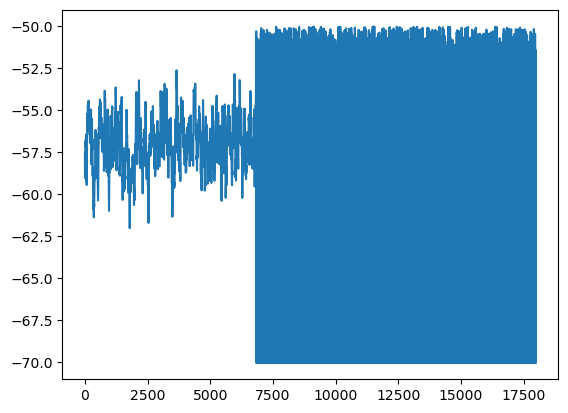

In [5]:
import pandas as pd
import numpy as np
from scripts import neuron_categorization, optimization, model, visualizations, preprocessing
import matplotlib.pyplot as plt

spike_trains = np.load('/hpc/mzhu843/modelling/nest/DATA/processed/spikes/S_3_p.npy')
calcium_traces = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')
ez_track_data = pd.read_csv('/hpc/mzhu843/modelling/nest/DATA/raw/ezytrack/behaviour_LocationOutput.csv')

categorizer = neuron_categorization.NeuronCategorizer(spike_trains, calcium_traces, ez_track_data)
categorizer.run_categorization()

weights = optimization.initialize_connectivity_matrix_normal_distribution(categorizer.get_categorized_neurons())

model = model.NeuronalNetwork(weights, categorizer.get_categorized_neurons(), G_e=4)

model.simulate()

voltages_trace_pyr = model.voltage_traces_pyr



ts = range(len(voltages_trace_pyr[2]))


plt.plot(ts, voltages_trace_pyr[2])
plt.show()










In [2]:
calcium = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')
print(np.max(calcium[2]))

25.218059079940137
